# **Extract, Transform, Load**

## Objectives

* Fetch data from Kaggle and save as raw data
* Clean and transform data
* Engineer features for modelling
* Validate and document etl process

## Inputs

* data/raw/hotel_bookings.csv

## Outputs

* hotel_bookings_clean.csv
* hotel_bookings_sample.csv

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'd:\\vscode-projects\\CancelScope-Hotel-Booking-Analysis\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'd:\\vscode-projects\\CancelScope-Hotel-Booking-Analysis'

# Data understanding, cleaning, preprocessing

Importing neccessary libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Read and extract dataset

In [5]:
df = pd.read_csv("data/raw/hotel_bookings.csv")

In [6]:
def review_dataframe(df):
    """
    Prints a summary of the dataframe including shape, duplicate count,
    and for each column: type, missing count, unique count, and sample values.
    """
    print(f"shape: {df.shape}") # (rows, columns)
    print(f"duplicates: {df.duplicated().sum()}\n") # count of duplicate rows

    print(f"{'column':<30} {'type':<12} {'missing':<8} {'unique':<8} {'sample values'}")
    print("\n")
    for col in df.columns:
        dtype = df[col].dtype
        missing = df[col].isnull().sum()
        unique_count = df[col].nunique(dropna=True)
        sample_values = df[col].dropna().unique()[:5]
        print(f"{col:<30} {str(dtype):<12} {missing:<8} {unique_count:<8} {sample_values}")

Visualise columns and statistics in a read friendly format

In [7]:
review_dataframe(df)

shape: (119390, 32)
duplicates: 31994

column                         type         missing  unique   sample values


hotel                          object       0        2        ['Resort Hotel' 'City Hotel']
is_canceled                    int64        0        2        [0 1]
lead_time                      int64        0        479      [342 737   7  13  14]
arrival_date_year              int64        0        3        [2015 2016 2017]
arrival_date_month             object       0        12       ['July' 'August' 'September' 'October' 'November']
arrival_date_week_number       int64        0        53       [27 28 29 30 31]
arrival_date_day_of_month      int64        0        31       [1 2 3 4 5]
stays_in_weekend_nights        int64        0        17       [0 1 2 4 3]
stays_in_week_nights           int64        0        35       [0 1 2 3 4]
adults                         int64        0        14       [ 2  1  3  4 40]
children                       float64      4        5        [ 0. 

In [8]:
df = df.drop_duplicates() #remove duplicate rows
df = df.dropna(subset=['children', 'country',]) #remove rows with missing values in children and country columns
df.shape

(86940, 32)

Columns to drop:
- meal - meal type can often be changed after arrival at the hotel 
- booking_changes - booking changes directly correspond with group booking
- agent - mostly IDs or missing values, and does not provide meaningful predictive information for cancellations
- company - again, mostly IDs or missing values, and is not useful for modeling cancellations
- adr - average revenue earned per day per occupied room,measures pricing and revenue performance, not needed for the current analysis
- required_car_parking_spaces - high correspondance to group visits, could misslead analysis
- total_of_special_requests - high correspondance to group visits, could misslead analysis
- reservation_status - describes a final state of reservation, already captured in is_canceled
- reservation_status_date - records the date when the reservation status was set,it is only known after the booking outcome so it cannot be used for predicting cancellations at the time of booking
- arrival_date_week_number - redundant with arrival_date_month and arrival_date_day_of_month, and does not add predictive value for cancellations

In [9]:
df = df.drop([
    'meal',
    'agent',
    'booking_changes',
    'company',
    'adr',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'reservation_status',
    'reservation_status_date',
    'arrival_date_week_number'
], axis=1)
df.shape


(86940, 22)

In [10]:
cancelled_diff_room_type = df[
    (df['is_canceled'] == 1) & 
    (df['assigned_room_type'] != df['reserved_room_type'])
]
count = cancelled_diff_room_type.shape[0]
print(f"assigned/reserved mismatch: {count}")

assigned/reserved mismatch: 609


In [11]:
mismatch_canceled = df[(df['is_canceled'] == 1) & (df['reserved_room_type'] != df['assigned_room_type'])].shape[0]
percent_canceled_mismatch = mismatch_canceled / df['is_canceled'].sum() * 100

print(f"mismatched and canceled: {mismatch_canceled}")
print(f"% of total canceled bookings that had a mismatch: {percent_canceled_mismatch:.2f}%")


mismatched and canceled: 609
% of total canceled bookings that had a mismatch: 2.54%


In [12]:
df = df.drop(['assigned_room_type', 'reserved_room_type'], axis=1)


 reserved_room_type and assigned_room_type were dropped because asigned_room_type is only recorded after check-in so it is not relevant for analysis of pre -arrival data and could introduce inconsistencies. Reserved_room_type provides limited insight for the current analysis and may be redundant with other booking information. Removing both columns simplifies the dataset and ensures only relevant & reliable features are retained for downstream processing. Also, room types are just indicative and do not describe the real room type. Further analysis for that which room is prefered or not cannot be done due to the lack of information.

# New Features

In [13]:
import calendar

# Create a mapping from month name to month number
month_map = {month: str(index).zfill(2) for index, month in enumerate(calendar.month_name) if month}

df['arrival_date'] = pd.to_datetime(
    df['arrival_date_day_of_month'].astype(str).str.zfill(2) + '-' +
    df['arrival_date_month'].map(month_map) + '-' +
    df['arrival_date_year'].astype(str),
    format='%d-%m-%Y',
    dayfirst=True
)

print(df['arrival_date'].nunique()) # verify number of unique values in the column
print(df['arrival_date'].head()) # display first 5

793
0   2015-07-01
1   2015-07-01
2   2015-07-01
3   2015-07-01
4   2015-07-01
Name: arrival_date, dtype: datetime64[ns]


In [14]:
df = df.drop(['arrival_date_day_of_month', 'arrival_date_month', 'arrival_date_year'], axis=1) # drop the original columns

In [15]:
review_dataframe(df)

shape: (86940, 18)
duplicates: 6064

column                         type         missing  unique   sample values


hotel                          object       0        2        ['Resort Hotel' 'City Hotel']
is_canceled                    int64        0        2        [0 1]
lead_time                      int64        0        479      [342 737   7  13  14]
stays_in_weekend_nights        int64        0        15       [0 1 2 4 3]
stays_in_week_nights           int64        0        33       [0 1 2 3 4]
adults                         int64        0        14       [ 2  1  3  4 40]
children                       float64      0        5        [ 0.  1.  2. 10.  3.]
babies                         int64        0        5        [ 0  1  2 10  9]
country                        object       0        177      ['PRT' 'GBR' 'USA' 'ESP' 'IRL']
market_segment                 object       0        7        ['Direct' 'Corporate' 'Online TA' 'Offline TA/TO' 'Complementary']
distribution_channel        

Change types

In [16]:
df['children'] = df['children'].astype(int)
df['is_canceled'] = df['is_canceled'].astype(bool)
df['is_repeated_guest'] = df['is_repeated_guest'].astype(bool)


new columns:
- total_stay: a single numeric feature  is easier to analyze and model than two separate columns. Total length of stay often correlates with cancellation behaviourand is useful for EDA and models.
- is_family - vallue will be true for bookings with more than one adult and at least one child or baby and false otherwise. Family bookings may have different cancellation patterns and preferences.
- cancellation_ratio: represents the proportion of previous bookings that were canceled.The small value 1e-6 is added to the denominator to avoid division by zero. The column will clarify what fraction of the bookings that a gues made were canceled. For guests with no previous bookings at all (both fields zero), this ratio is zero.If there are many first-time guests with no booking history, then this feature will be zero for them which is logical.

In [17]:
df['total_stay'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
df['is_family'] = ((df['adults'] >= 1) & ((df['children'] >= 1) | (df['babies'] >= 1)))
df['cancellation_ratio'] = df['previous_cancellations'] / (df['previous_cancellations'] + df['previous_bookings_not_canceled'] + 1e-6)
df['total_guests'] = df['adults'] + df['children'] + df['babies']

In [18]:
df = df.drop(['previous_cancellations', 'previous_bookings_not_canceled'], axis=1)
df.shape

(86940, 20)

I decide to analyse deeper if 0 values of the stay_length correspond to canceled reservations, which would be a realistic scenario.
My hypotheseis is that if a reservation is NOT canceled (is_canceled=False) the stay in the hotel must be at least 1 night (stay_length >=1)

In [19]:
not_canceled_zero_stay = df[(df['is_canceled'] == False) & (df['total_stay'] == 0)]
print(f"Rows where reservation was not canceled and stay length is zero: {not_canceled_zero_stay.shape[0]}")


Rows where reservation was not canceled and stay length is zero: 617


The above check shows lack of llogic in a real-world hotel data. A non-canceled reservation should have at least one night. For that reason I decide to remove the 617 rows with not canceled reservations but zero stay length, as they represent some kind of data error.

In [20]:
df = df[~((df['is_canceled'] == False) & (df['total_stay'] == 0))]
df.shape

(86323, 20)

In [21]:
review_dataframe(df)

shape: (86323, 20)
duplicates: 6183

column                         type         missing  unique   sample values


hotel                          object       0        2        ['Resort Hotel' 'City Hotel']
is_canceled                    bool         0        2        [False  True]
lead_time                      int64        0        478      [ 7 13 14  0  9]
stays_in_weekend_nights        int64        0        15       [0 1 2 4 3]
stays_in_week_nights           int64        0        33       [1 2 3 4 5]
adults                         int64        0        14       [ 1  2  3  4 40]
children                       int32        0        5        [ 0  1  2 10  3]
babies                         int64        0        5        [ 0  1  2 10  9]
country                        object       0        177      ['GBR' 'PRT' 'USA' 'ESP' 'IRL']
market_segment                 object       0        7        ['Direct' 'Corporate' 'Online TA' 'Offline TA/TO' 'Complementary']
distribution_channel          

In [22]:
df = df.drop_duplicates()
df.shape

(80140, 20)

In [23]:
df = df.rename(columns={
    'stays_in_weekend_nights': 'weekend_nights',
    'stays_in_week_nights': 'week_nights',
    'days_in_waiting_list': 'days_waiting'
})


In [24]:
def clean_string_columns(df):
    """
    Cleans string columns in the given DataFrame by converting all text to lowercase
    and replacing '-', '!', '/', and spaces with underscores. Only columns with
    object (string) dtype are processed.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame whose string columns will be cleaned.

    Returns
    -------
    pandas.DataFrame
        The DataFrame with cleaned string columns.
    """
    # Only apply to object (string) columns
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].str.lower().str.replace(r'[-!/ ]', '_', regex=True)
    return df

df = clean_string_columns(df)

In [25]:
review_dataframe(df)

shape: (80140, 20)
duplicates: 0

column                         type         missing  unique   sample values


hotel                          object       0        2        ['resort_hotel' 'city_hotel']
is_canceled                    bool         0        2        [False  True]
lead_time                      int64        0        478      [ 7 13 14  0  9]
weekend_nights                 int64        0        15       [0 1 2 4 3]
week_nights                    int64        0        33       [1 2 3 4 5]
adults                         int64        0        14       [ 1  2  3  4 40]
children                       int32        0        5        [ 0  1  2 10  3]
babies                         int64        0        5        [ 0  1  2 10  9]
country                        object       0        177      ['gbr' 'prt' 'usa' 'esp' 'irl']
market_segment                 object       0        7        ['direct' 'corporate' 'online_ta' 'offline_ta_to' 'complementary']
distribution_channel           ob

# Check and Handle Outliars

In [ ]:
# Numeric columns for outlier detection
numeric_cols = ['adults', 'children', 'babies', 'total_stay', 'weekend_nights', 'week_nights', 'total_guests', 'lead_time', 'days_waiting']

# Check for outliers in numeric columns using IQR method
for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {outliers.shape[0]} outliers")

adults: 20611 outliers
children: 8115 outliers
babies: 887 outliers
total_stay: 2796 outliers
weekend_nights: 208 outliers
week_nights: 1415 outliers
total_guests: 27811 outliers
lead_time: 2235 outliers
days_waiting: 654 outliers


Some of these outliars may be true values (e.g., large groups or long stays), so I will investigate them further

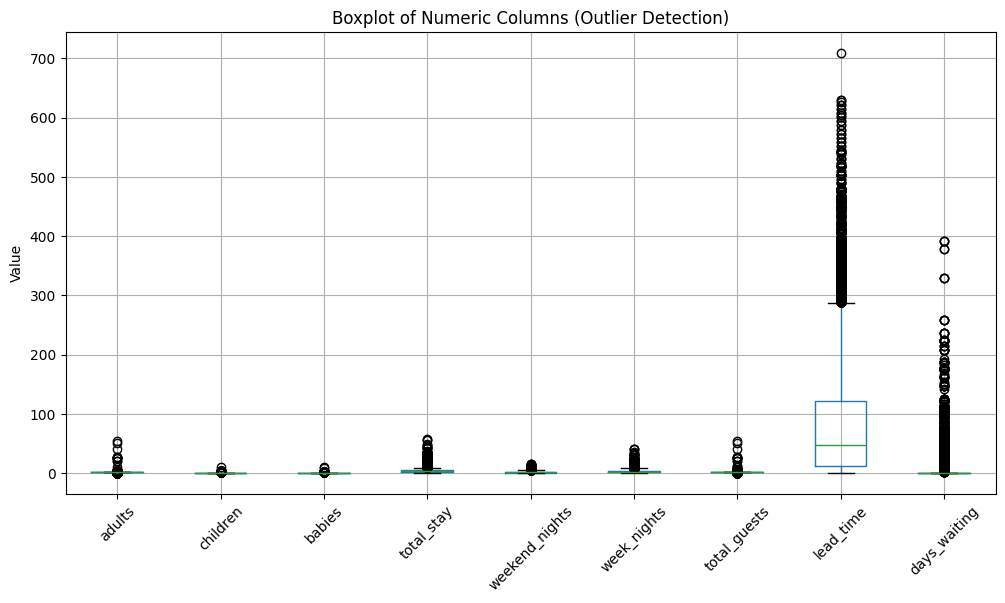

In [28]:
plt.figure(figsize=(12, 6))
df[numeric_cols].boxplot()
plt.title("Boxplot of Numeric Columns (Outlier Detection)")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.show()

In [29]:
for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"\nTop 5 outliers for '{col}':")
    print(outliers[[col]].sort_values(by=col, ascending=False).head(5))


Top 5 outliers for 'adults':
      adults
2173      55
1643      50
1539      40
1962      27
1917      27

Top 5 outliers for 'children':
        children
328           10
18746          3
118200         3
115891         3
92415          3

Top 5 outliers for 'babies':
       babies
46619      10
78656       9
7896        2
39634       2
6719        2

Top 5 outliers for 'total_stay':
        total_stay
101794          57
33924           56
9839            56
88017           49
54704           48

Top 5 outliers for 'weekend_nights':
        weekend_nights
33924               16
9839                16
101794              16
54704               14
88017               14

Top 5 outliers for 'week_nights':
        week_nights
101794           41
33924            40
9839             40
88017            35
54704            34

Top 5 outliers for 'total_guests':
      total_guests
2173            55
1643            50
1539            40
1917            27
1962            27

Top 5 outliers

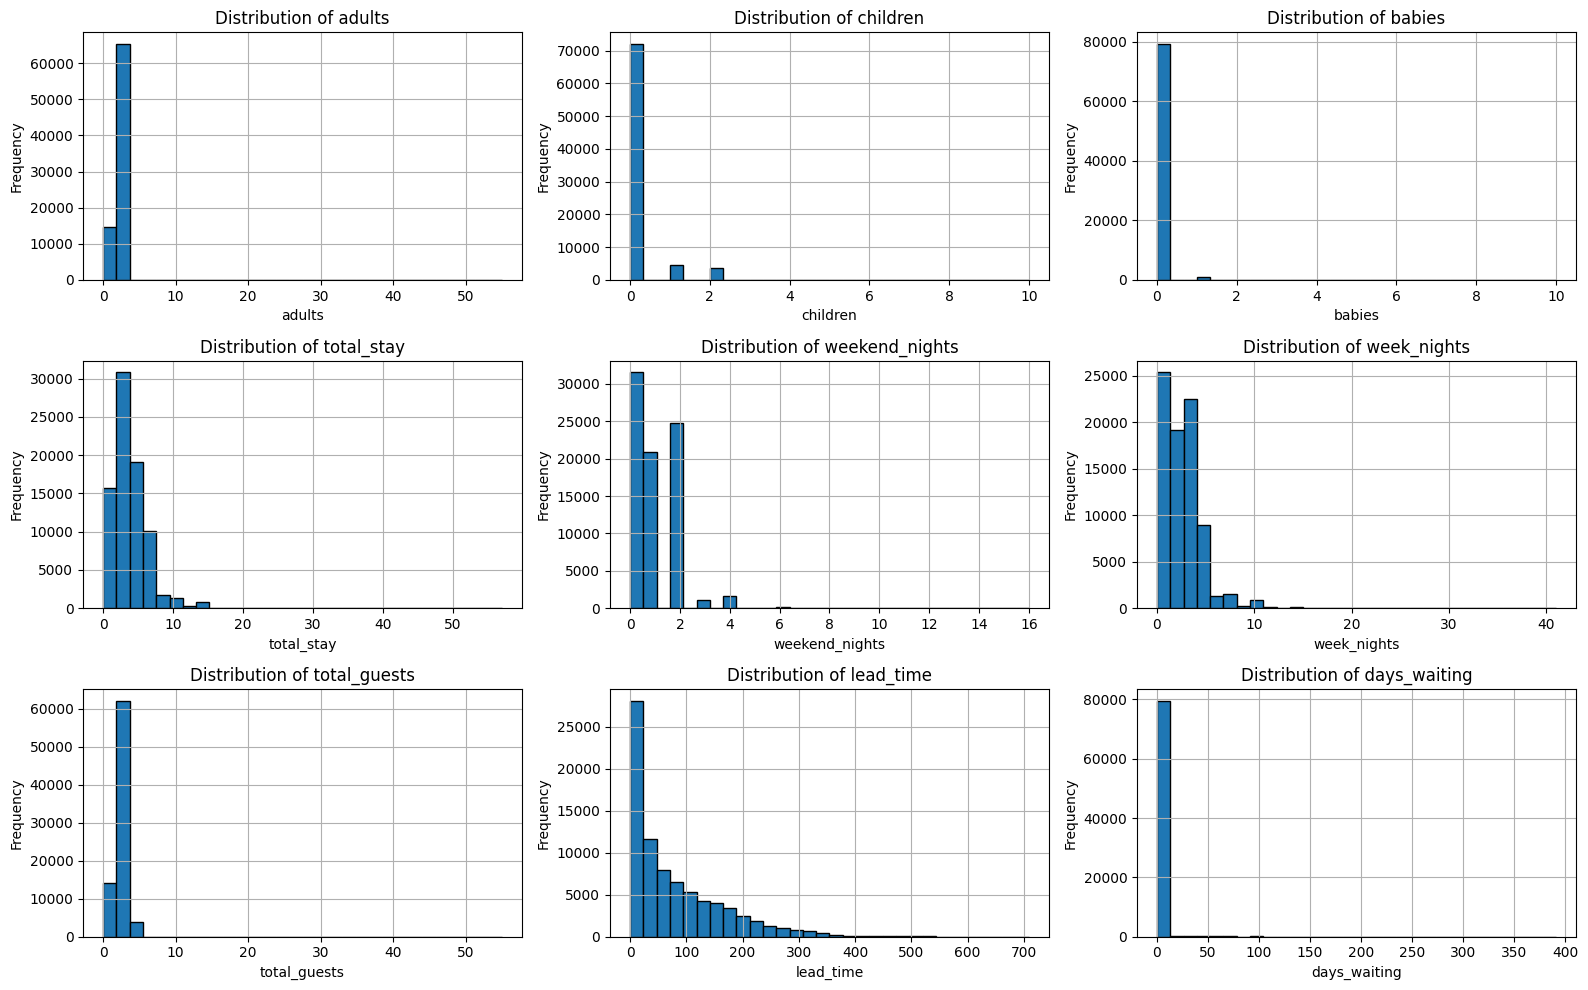

In [30]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    df[col].hist(bins=30, edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* In cases where you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [27]:
import os
try:
  # create your folder here
  # os.makedirs(name='')
except Exception as e:
  print(e)


IndentationError: expected an indented block after 'try' statement on line 2 (553063055.py, line 5)